In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('events.csv')

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))

# Diviser entre transactions et le reste
non_transactions = df.loc[df.event != "transaction"]
transactions = df.loc[df.event == "transaction"]

In [2]:
# Créer un dataframe par merge inner
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Calculez la différence entre l'heure à laquelle la transaction s'est produite
# et l'heure à laquelle chaque événement s'est produit
inner_merged_total['time_diff'] = inner_merged_total['date_x'] - inner_merged_total['date_y']

# Trier le dataframe par visitorid...
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_x','date_y','itemid_x'])

# Appliquer 2 conditions importantes pour définir une visite convertissante : 
# Premièrement, time_diff est moins de 24h. Deuxièmement, le itemid sur lequel la transaction 
# a eu lieu et le itemid sur lequel chaque événement s'est produit doivent être les mêmes
transaction_24h = inner_merged_total.loc[inner_merged_total['time_diff'].dt.days < 1]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)

# Convertir 'time_diff' en timedelta en seconds
transaction_made_24h['time_diff_sec'] = transaction_made_24h['time_diff'].dt.seconds
transaction_made_24h

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,time_diff,time_diff_sec
10069099,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,0 days 00:22:22.792000,1342
10069108,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,0 days 00:15:21.539000,921
10069105,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,0 days 00:15:12.906000,912
10069098,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:09.037,0 days 00:01:52.193000,112
10069106,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:27.421,0 days 00:01:33.809000,93
...,...,...,...,...,...,...,...,...,...,...
9743949,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 00:57:13.885,0 days 00:14:11.739000,851
9743946,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:00:26.861,0 days 00:10:58.763000,658
9743942,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:03:14.670,0 days 00:08:10.954000,490
9743943,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,addtocart,360922,2015-08-05 01:05:35.724,0 days 00:05:49.900000,349


In [3]:
# Grouper par transactionid
group_transaction = transaction_made_24h.groupby('transactionid_x')

# Calculer le temps total par transactionid
#time_sum_transaction = transaction_made_24h.groupby(by=['transactionid_x']).sum()

# Calculer le temps moyen par transactionid
time_mean_transaction = transaction_made_24h.groupby(by=['transactionid_x']).mean()
time_mean_transaction = time_mean_transaction.drop(['visitorid','itemid_x','itemid_y'], axis=1)
time_mean_transaction = time_mean_transaction.rename(columns={"time_diff_sec": "mean_time_second"})
time_mean_transaction

,mean_time_second
transactionid_x,
0.0,7838.333333
1.0,39733.750000
2.0,189.000000
4.0,21935.625000
6.0,108.000000
...,...
17667.0,10988.800000
17668.0,146.000000
17669.0,53412.666667


In [4]:
time_mean_transaction.describe()

,mean_time_second
count,17455.000000
mean,11923.517782
std,17033.660310
min,8.000000
25%,237.500000
50%,951.250000
75%,22593.375000
max,86381.500000


In [6]:
# Clustering transactions 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
s_scores = []

for i in range_n_clusters:
    cluster = AgglomerativeClustering(n_clusters = i)
    cluster.fit(time_mean_transaction)
    s_scores.append(silhouette_score(time_mean_transaction, cluster.labels_, metric='sqeuclidean'))
    
s_scores

# best score : 3

[0.8244151265426732,
 0.8832049382766468,
 0.8715946837669521,
 0.8719869536883444,
 0.8527301357019487,
 0.8505300745687305,
 0.8489207333166787,
 0.8454378341339548,
 0.8649220613619355,
 0.8614393435925692,
 0.8385829784316096,
 0.8472741368392263,
 0.849355082253998]

In [98]:
# AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 3)

# Apprentissage des données 
cluster.fit(time_mean_transaction)

# Calcul des labels du data set
labels = cluster.labels_

# Convertir time
time_mean_transaction['label_clustering'] = labels
time_mean_transaction['mean_time_minute'] = round(time_mean_transaction['mean_time_second']/60)
time_mean_transaction['mean_time_hour'] = round(time_mean_transaction['mean_time_second']/3600,2)
time_mean_transaction

# Clustering, Nombre total par label
group_label_clustering = time_mean_transaction.groupby('label_clustering').count()
group_label_clustering = group_label_clustering.rename(columns={"mean_time_second": "nb_transactions"})
group_label_clustering

# Temps de Transactions moins d'une heure
mean_transaction_1h = time_mean_transaction.loc[round(time_mean_transaction['mean_time_minute']) <= 60]

# Temps de transactions moins de 10 minutes
mean_transaction_10minutes = mean_transaction_1h.loc[round(mean_transaction_1h['mean_time_minute']) <= 10]

Label 0 : Temps moyens passé avant la transaction entre 11h et 24h
Label 1 : Temps moyens passé avant la transaction égale à moins de 3h
Label 2 : Temps moyens passé avant la transaction entre 3h et 11h


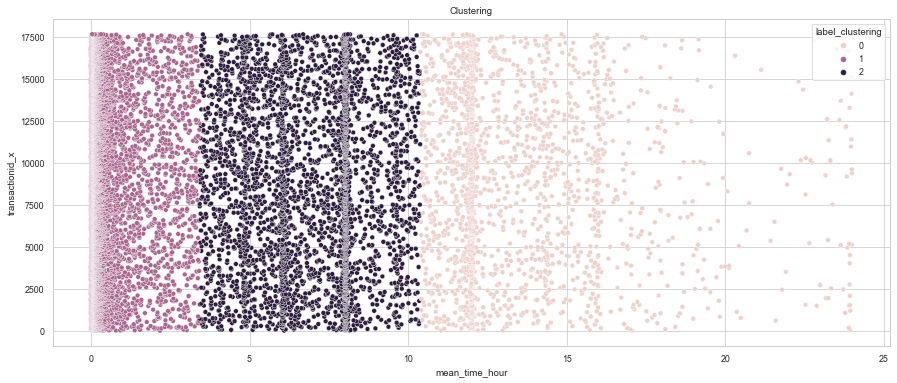

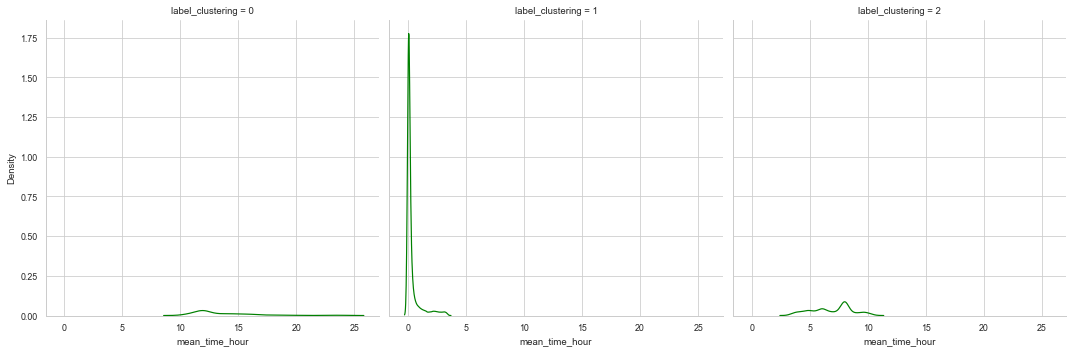

In [136]:
# Pour mieux comprendre le résultat du clustering
import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=time_mean_transaction, x="mean_time_hour", y=time_mean_transaction.index, hue="label_clustering",)
plt.title('Clustering')

sns.displot(data=time_mean_transaction, x="mean_time_hour", col="label_clustering", kind="kde", color='green')

print("Label 0 : Temps moyens passé avant la transaction compris entre 11h et 24h")
print("Label 1 : Temps moyens passé avant la transaction compris égale à moins de 3h")
print("Label 2 : Temps moyens passé avant la transaction compris entre 3h et 11h")


Text(0.5, 1.0, 'Temps moyens passé avant la transaction compris égale à moins de 10 minutes')

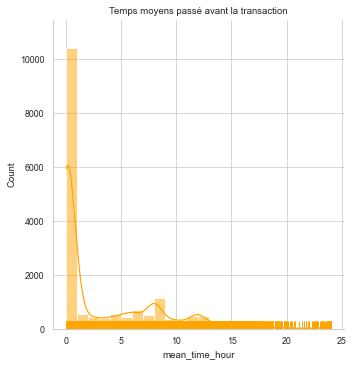

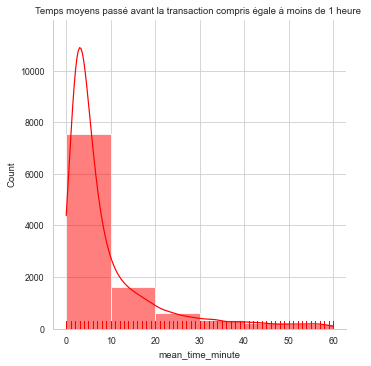

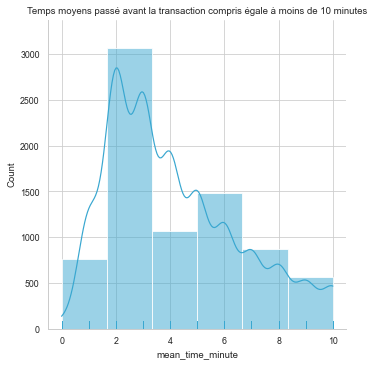

In [137]:
sns.displot(time_mean_transaction['mean_time_hour'], bins=24, kde=True, rug=True, color='orange')
plt.title('Temps moyens passé avant la transaction')

sns.displot(mean_transaction_1h['mean_time_minute'], bins=6, kde=True, rug=True, color='red')
plt.title('Temps moyens passé avant la transaction compris égale à moins de 1 heure ')
          
sns.displot(mean_transaction_10minutes['mean_time_minute'], bins=6, kde=True, rug=True)
plt.title('Temps moyens passé avant la transaction compris égale à moins de 10 minutes')

<AxesSubplot:xlabel='label_clustering', ylabel='nb_transactions'>

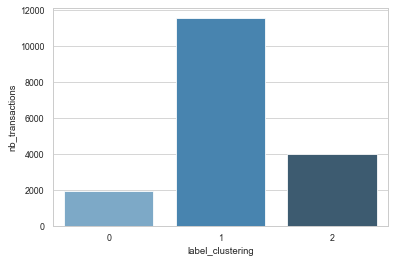

In [138]:
# Barplot
sns.barplot(x=group_label_clustering.index, y=group_label_clustering['nb_transactions'], data=group_label_clustering, palette="Blues_d")

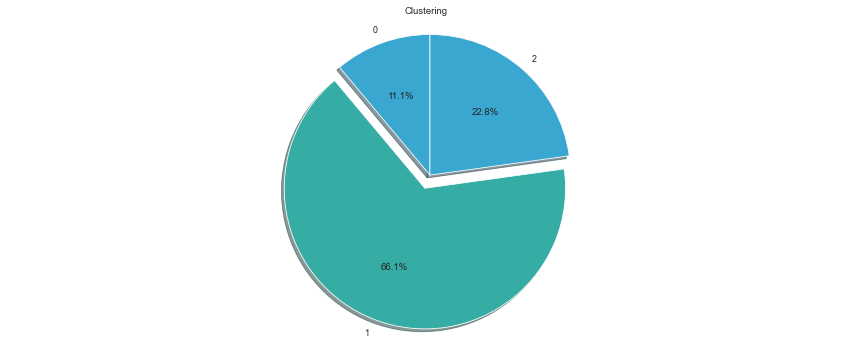

In [143]:
fig1, ax1 = plt.subplots(figsize=(15,6))
ax1.pie(group_label_clustering['nb_transactions'], explode=[0, 0.1, 0], labels=['0', '1', '2'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Clustering')
plt.show()